In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('Trading-features.csv').dropna().drop_duplicates().sample(frac=1).reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S')  # Combine date and time
df['created_at'] = df['created_at'].dt.strftime('%H:%M:%S')
df.set_index('created_at', inplace=True)
df['last_price'] = pd.to_numeric(df['last_price'], errors='coerce')

In [3]:
df['sec'] = df['date'].apply(lambda x: int(x[-2:]))
df['min'] = df['date'].apply(lambda x: int(x[-5:-3]))
df['hour'] = df['date'].apply(lambda x: int(x[-8:-6]))

/Users/hwaqar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


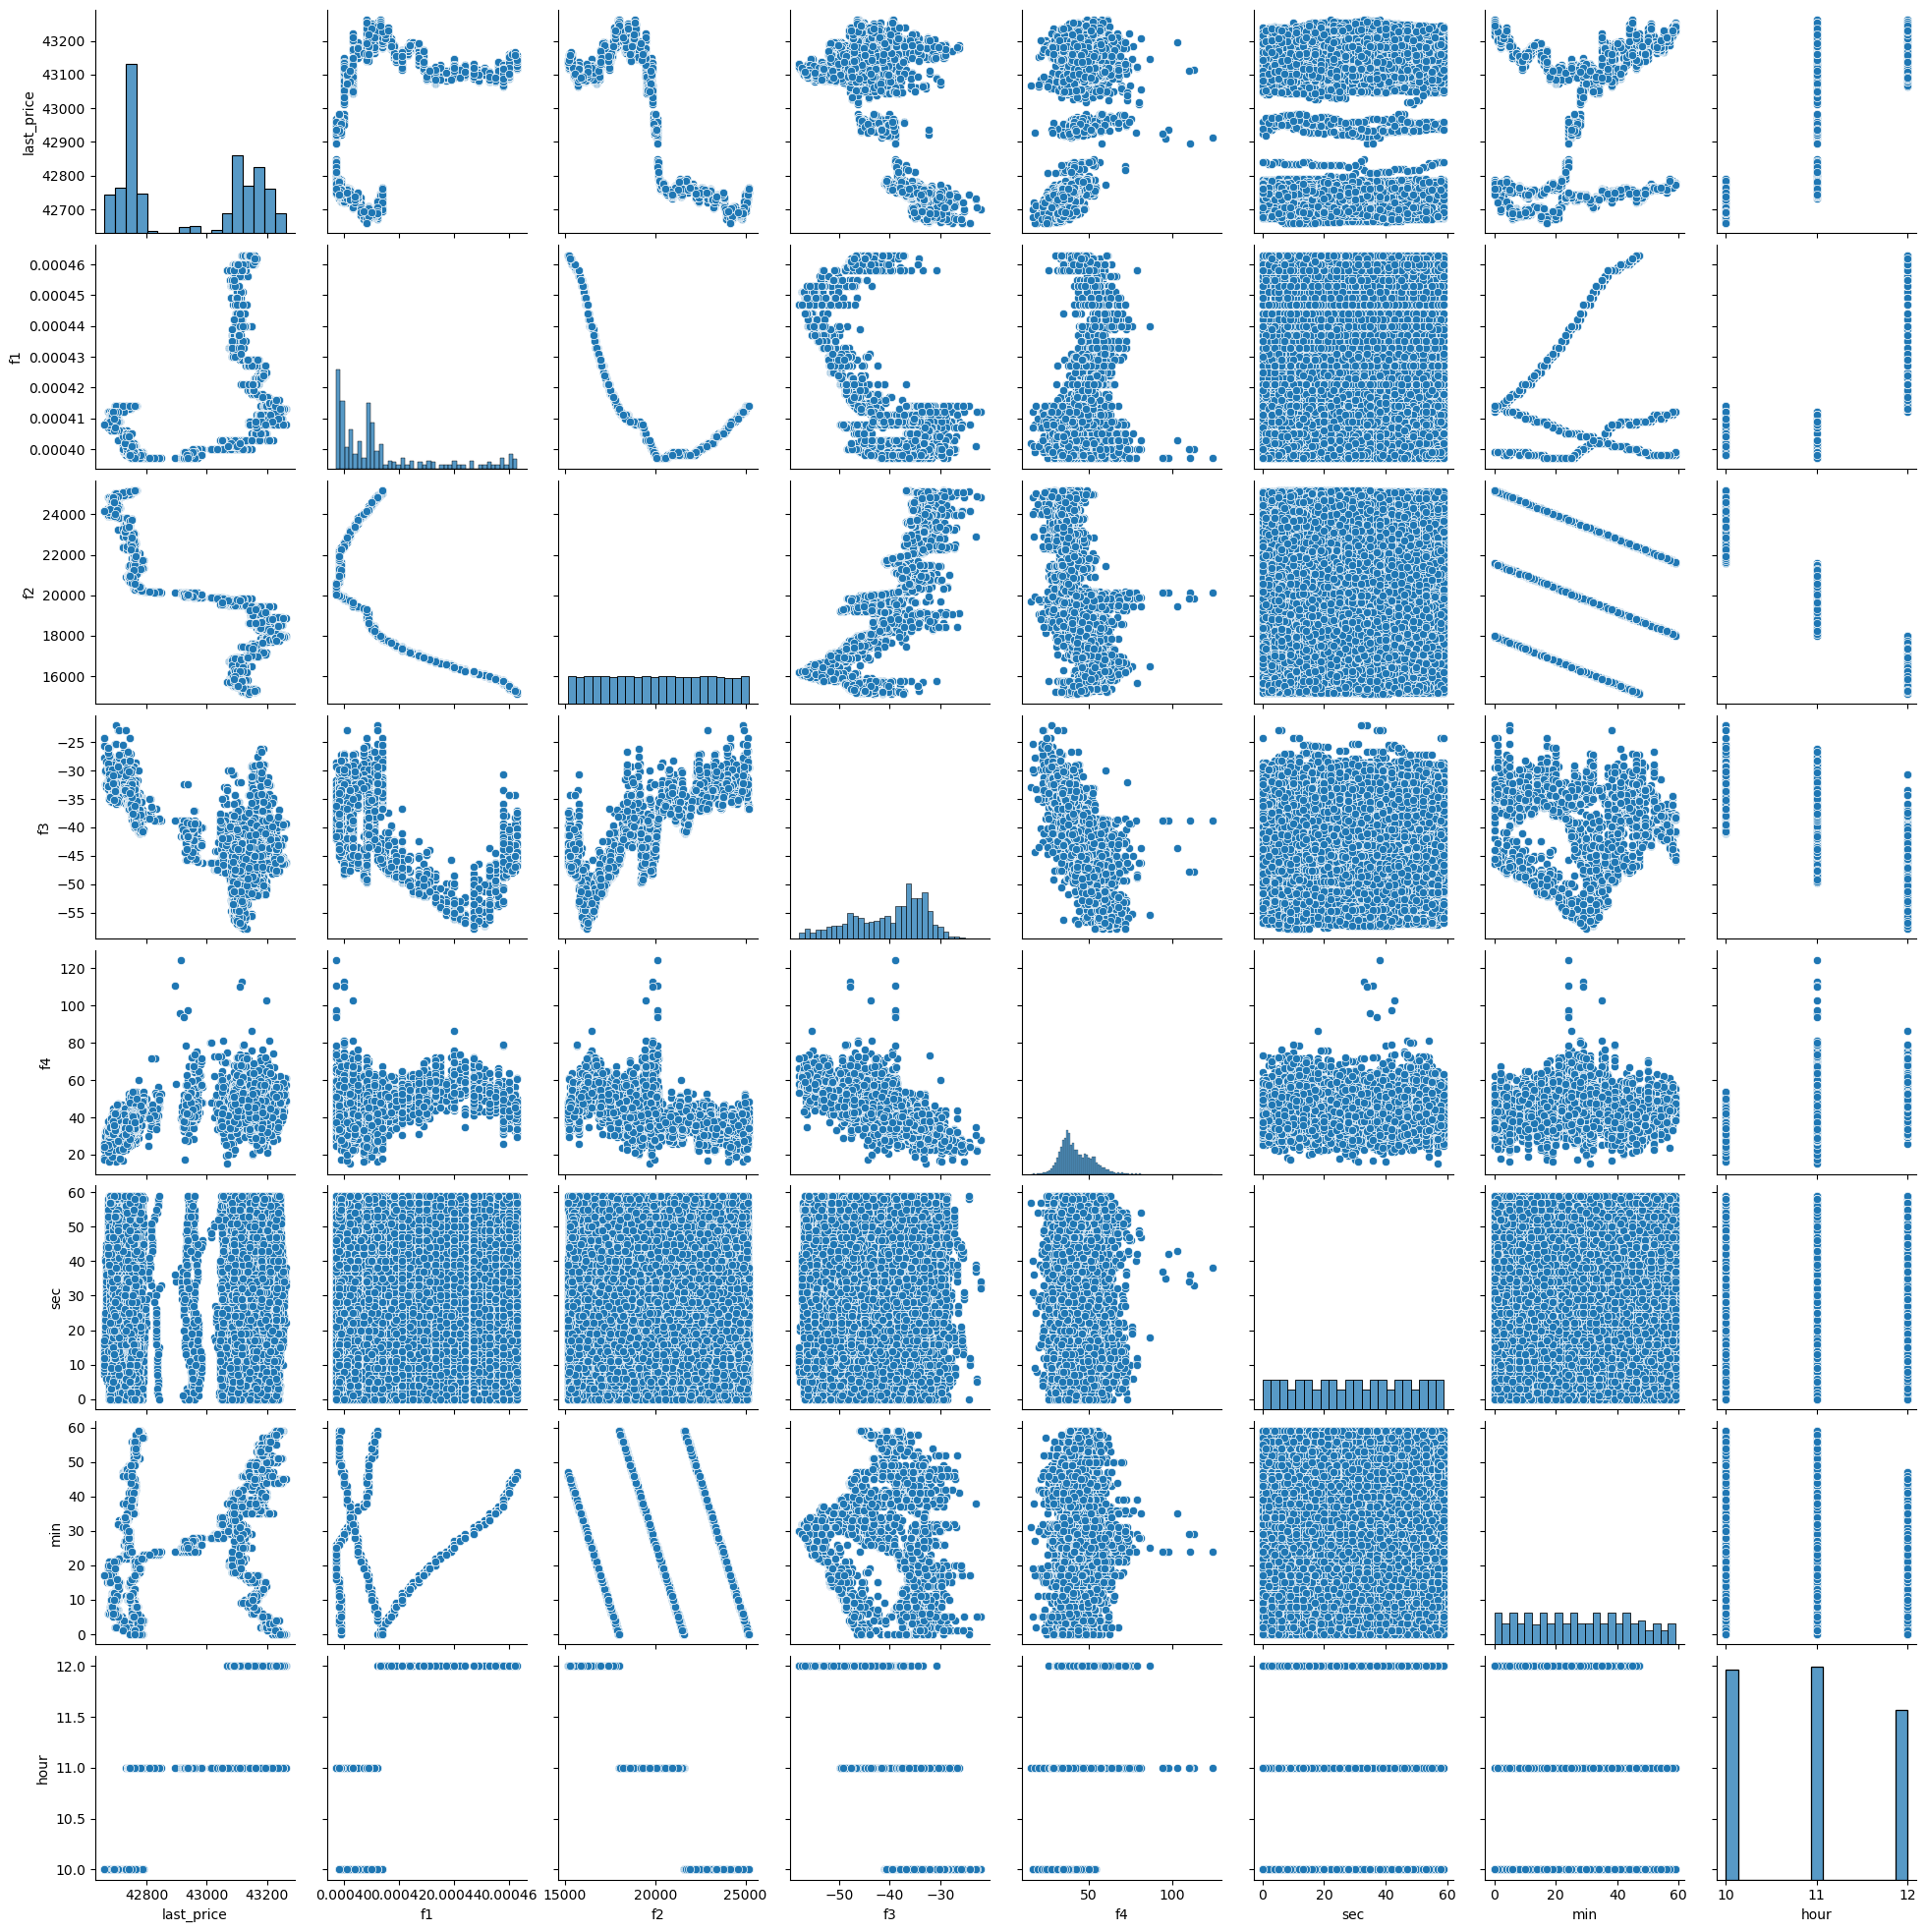

In [4]:
selected_columns = ['last_price', 'f1', 'f2', 'f3', 'f4', 'sec', 'min', 'hour']
sns.pairplot(df[selected_columns])
plt.show()

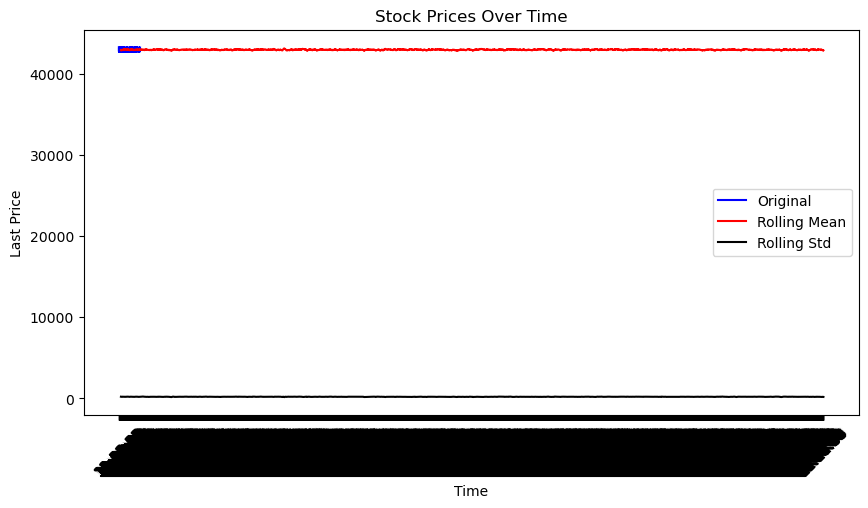

In [5]:
rolmean = df['last_price'].rolling(window=30).mean()
rolstd = df['last_price'].rolling(window=30).std()
plt.figure(figsize=(10, 5))
plt.plot(df['last_price'][:300], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Text(0.5, 0.98, '\nAdditive Decompose')

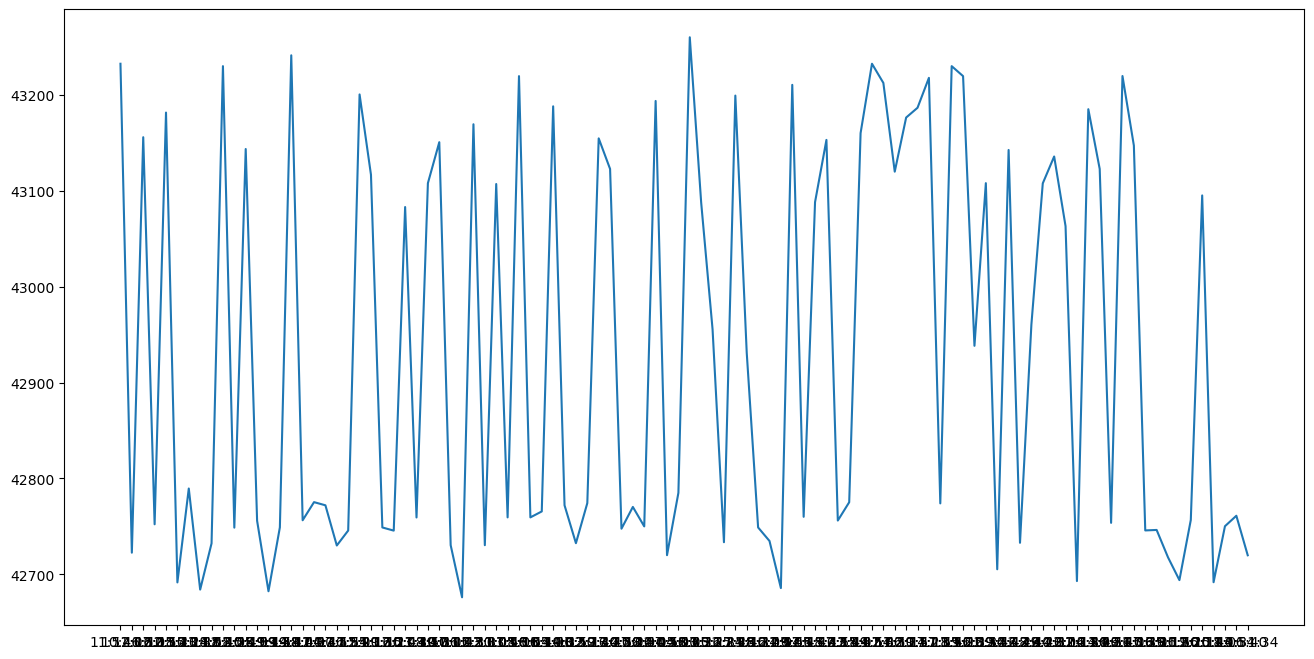

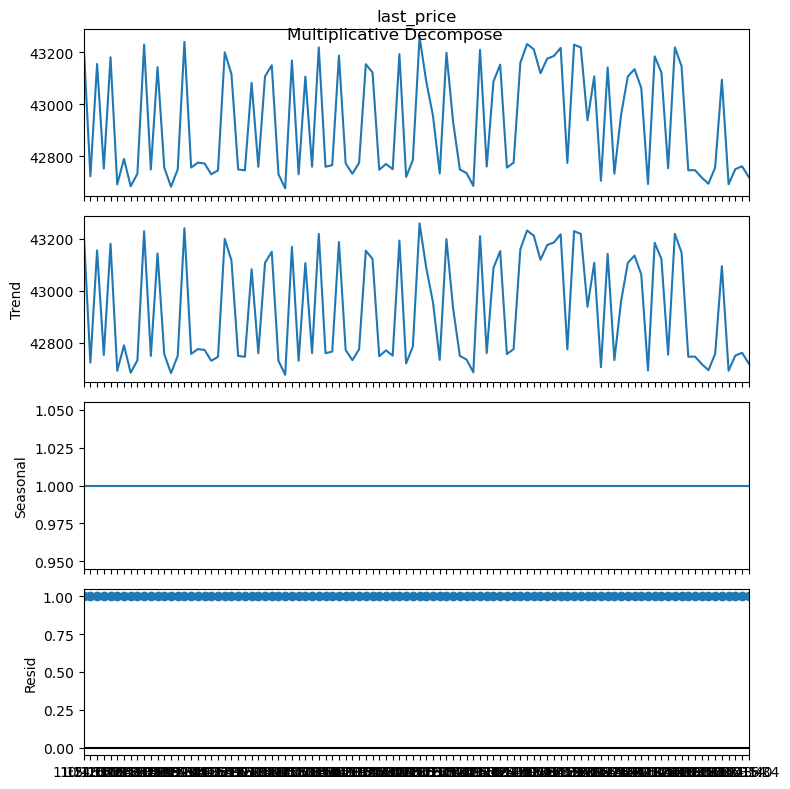

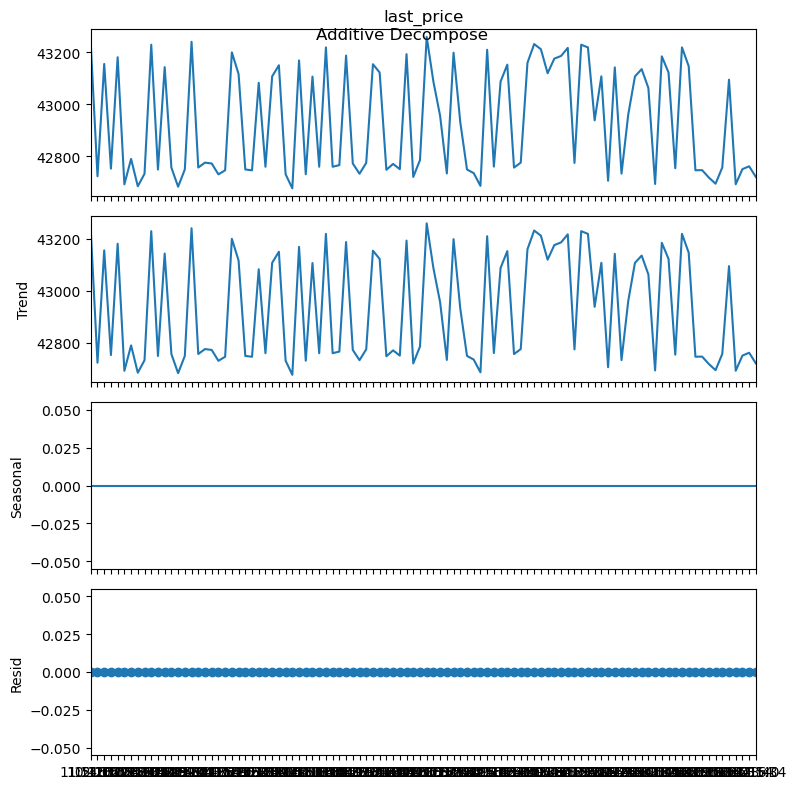

In [6]:
plt.rcParams.update({'figure.figsize': (16, 8)})
plt.plot(df['last_price'][:100])
mul_result = seasonal_decompose(df['last_price'][:100], model='multiplicative', period=1)
ad_result = seasonal_decompose(df['last_price'][:100], model='additive', period=1)
plt.rcParams.update({'figure.figsize': (8, 8)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)
plt.rcParams.update({'figure.figsize': (8, 8)})
ad_result.plot().suptitle('\nAdditive Decompose', fontsize=12)

In [7]:
adf_result = adfuller(df['last_price'], autolag='AIC')
print('ADF value:', adf_result[0])
print('P-value:', adf_result[1])

ADF value: -98.85086795268319
P-value: 0.0


In [8]:
df['target'] = df['last_price'].diff().apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(df.drop(['target'], axis=1), df['target'])

In [10]:
X = X_resampled.select_dtypes(include=['float64', 'int64'])
y = y_resampled

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100)

In [12]:
svc_model = SVC(kernel='rbf', probability=True).fit(X_train, y_train)

y_prob = svc_model.predict_proba(X_test)

In [13]:
threshold = 0.4  # Adjust this threshold accordingly
y_pred_adjusted = [1 if prob[1] > threshold else (0 if prob[0] > threshold else -1) for prob in y_prob]
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print(f"Accuracy with adjusted threshold: {accuracy_adjusted}")

Accuracy with adjusted threshold: 0.07378964941569283


In [21]:
class_report = classification_report(y_test, y_pred_adjusted)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.24      0.25      1002
           0       0.00      0.00      0.00      1019
           1       0.00      0.00      0.00       972

    accuracy                           0.08      2993
   macro avg       0.09      0.08      0.08      2993
weighted avg       0.09      0.08      0.08      2993



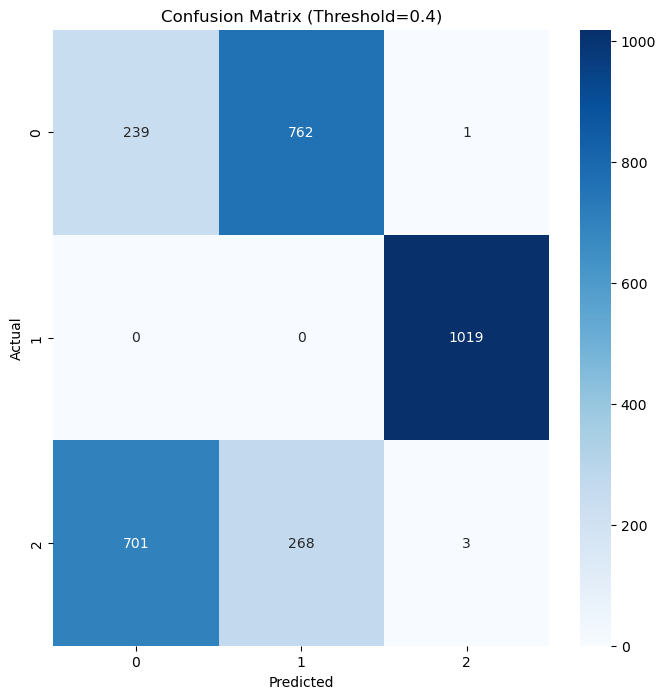

In [22]:
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold={threshold})')
plt.show()

In [15]:
df

id  last_price        f1     f2    f3    f4   f5    f6  \
created_at                                                                 
11:51:07    55463515     43232.4  0.000410  18533 -42.8  48.8  6.0   7.7   
10:46:52    55459663     42722.6  0.000400  22388 -27.3  27.4  0.1 -11.5   
12:16:18    55465027     43155.8  0.000427  17023 -51.3  52.6  1.3  -2.7   
11:12:55    55461225     42752.2  0.000398  20826 -33.6  33.6  0.0  -4.2   
12:05:41    55464391     43181.5  0.000417  17659 -42.6  41.3 -1.3 -15.4   
...              ...         ...       ...    ...   ...   ...  ...   ...   
10:10:13    55457506     42690.8  0.000410  24587 -35.2  35.9  0.7   8.5   
12:17:37    55465107     43136.8  0.000429  16943 -49.0  45.7 -3.3 -20.0   
11:17:00    55461470     42761.0  0.000397  20580 -36.3  37.3  1.0   3.1   
11:11:05    55461114     42744.1  0.000398  20935 -33.9  33.9  0.0 -10.0   
10:30:08    55458659     42739.4  0.000404  23392 -30.2  34.2  4.0  -3.0   

              f7    f8  ...   f157   f158   f159   f160   f161  \
created_at              ...                                      
11:51:07    26.4  85.0  ...  801.7  801.7  -29.4  -29.4  801.7   
10:46:52   -21.4 -21.4  ...  349.9  349.9  -72.3  -72.3  349.9   
12:16:18     2.5 -17.8  ...  725.1  725.1 -106.2 -106.2  725.1   
11:12:55    -1.8   0.6  ...  321.5  321.5  -42.7  -42.7  321.5   
12:05:41   -20.0 -33.1  ...  750.8  750.8  -80.5  -80.5  750.8   
...          ...   ...  ...    ...    ...    ...    ...    ...   
10:10:13     8.5   8.7  ...  355.8  355.8 -104.1 -104.1  355.8   
12:17:37   -11.3  -4.6  ...  706.1  706.1 -125.2 -125.2  706.1   
11:17:00     6.1  15.2  ...  330.3  330.3  -33.9  -33.9  330.3   
11:11:05     6.0  -1.5  ...  313.4  313.4  -50.8  -50.8  313.4   
10:30:08    -7.6  -5.7  ...  404.4  404.4  -55.5  -55.5  404.4   

                           date  sec  min  hour  target  
created_at                                               
11:51:07    2023-12-27 11:51:07    7   51    11      -1  
10:46:52    2023-12-27 10:46:52   52   46    10      -1  
12:16:18    2023-12-27 12:16:18   18   16    12       1  
11:12:55    2023-12-27 11:12:55   55   12    11      -1  
12:05:41    2023-12-27 12:05:41   41    5    12       1  
...                         ...  ...  ...   ...     ...  
10:10:13    2023-12-27 10:10:13   13   10    10      -1  
12:17:37    2023-12-27 12:17:37   37   17    12       1  
11:17:00    2023-12-27 11:17:00    0   17    11      -1  
11:11:05    2023-12-27 11:11:05    5   11    11      -1  
10:30:08    2023-12-27 10:30:08    8   30    10      -1  

[9979 rows x 168 columns]

/Users/hwaqar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


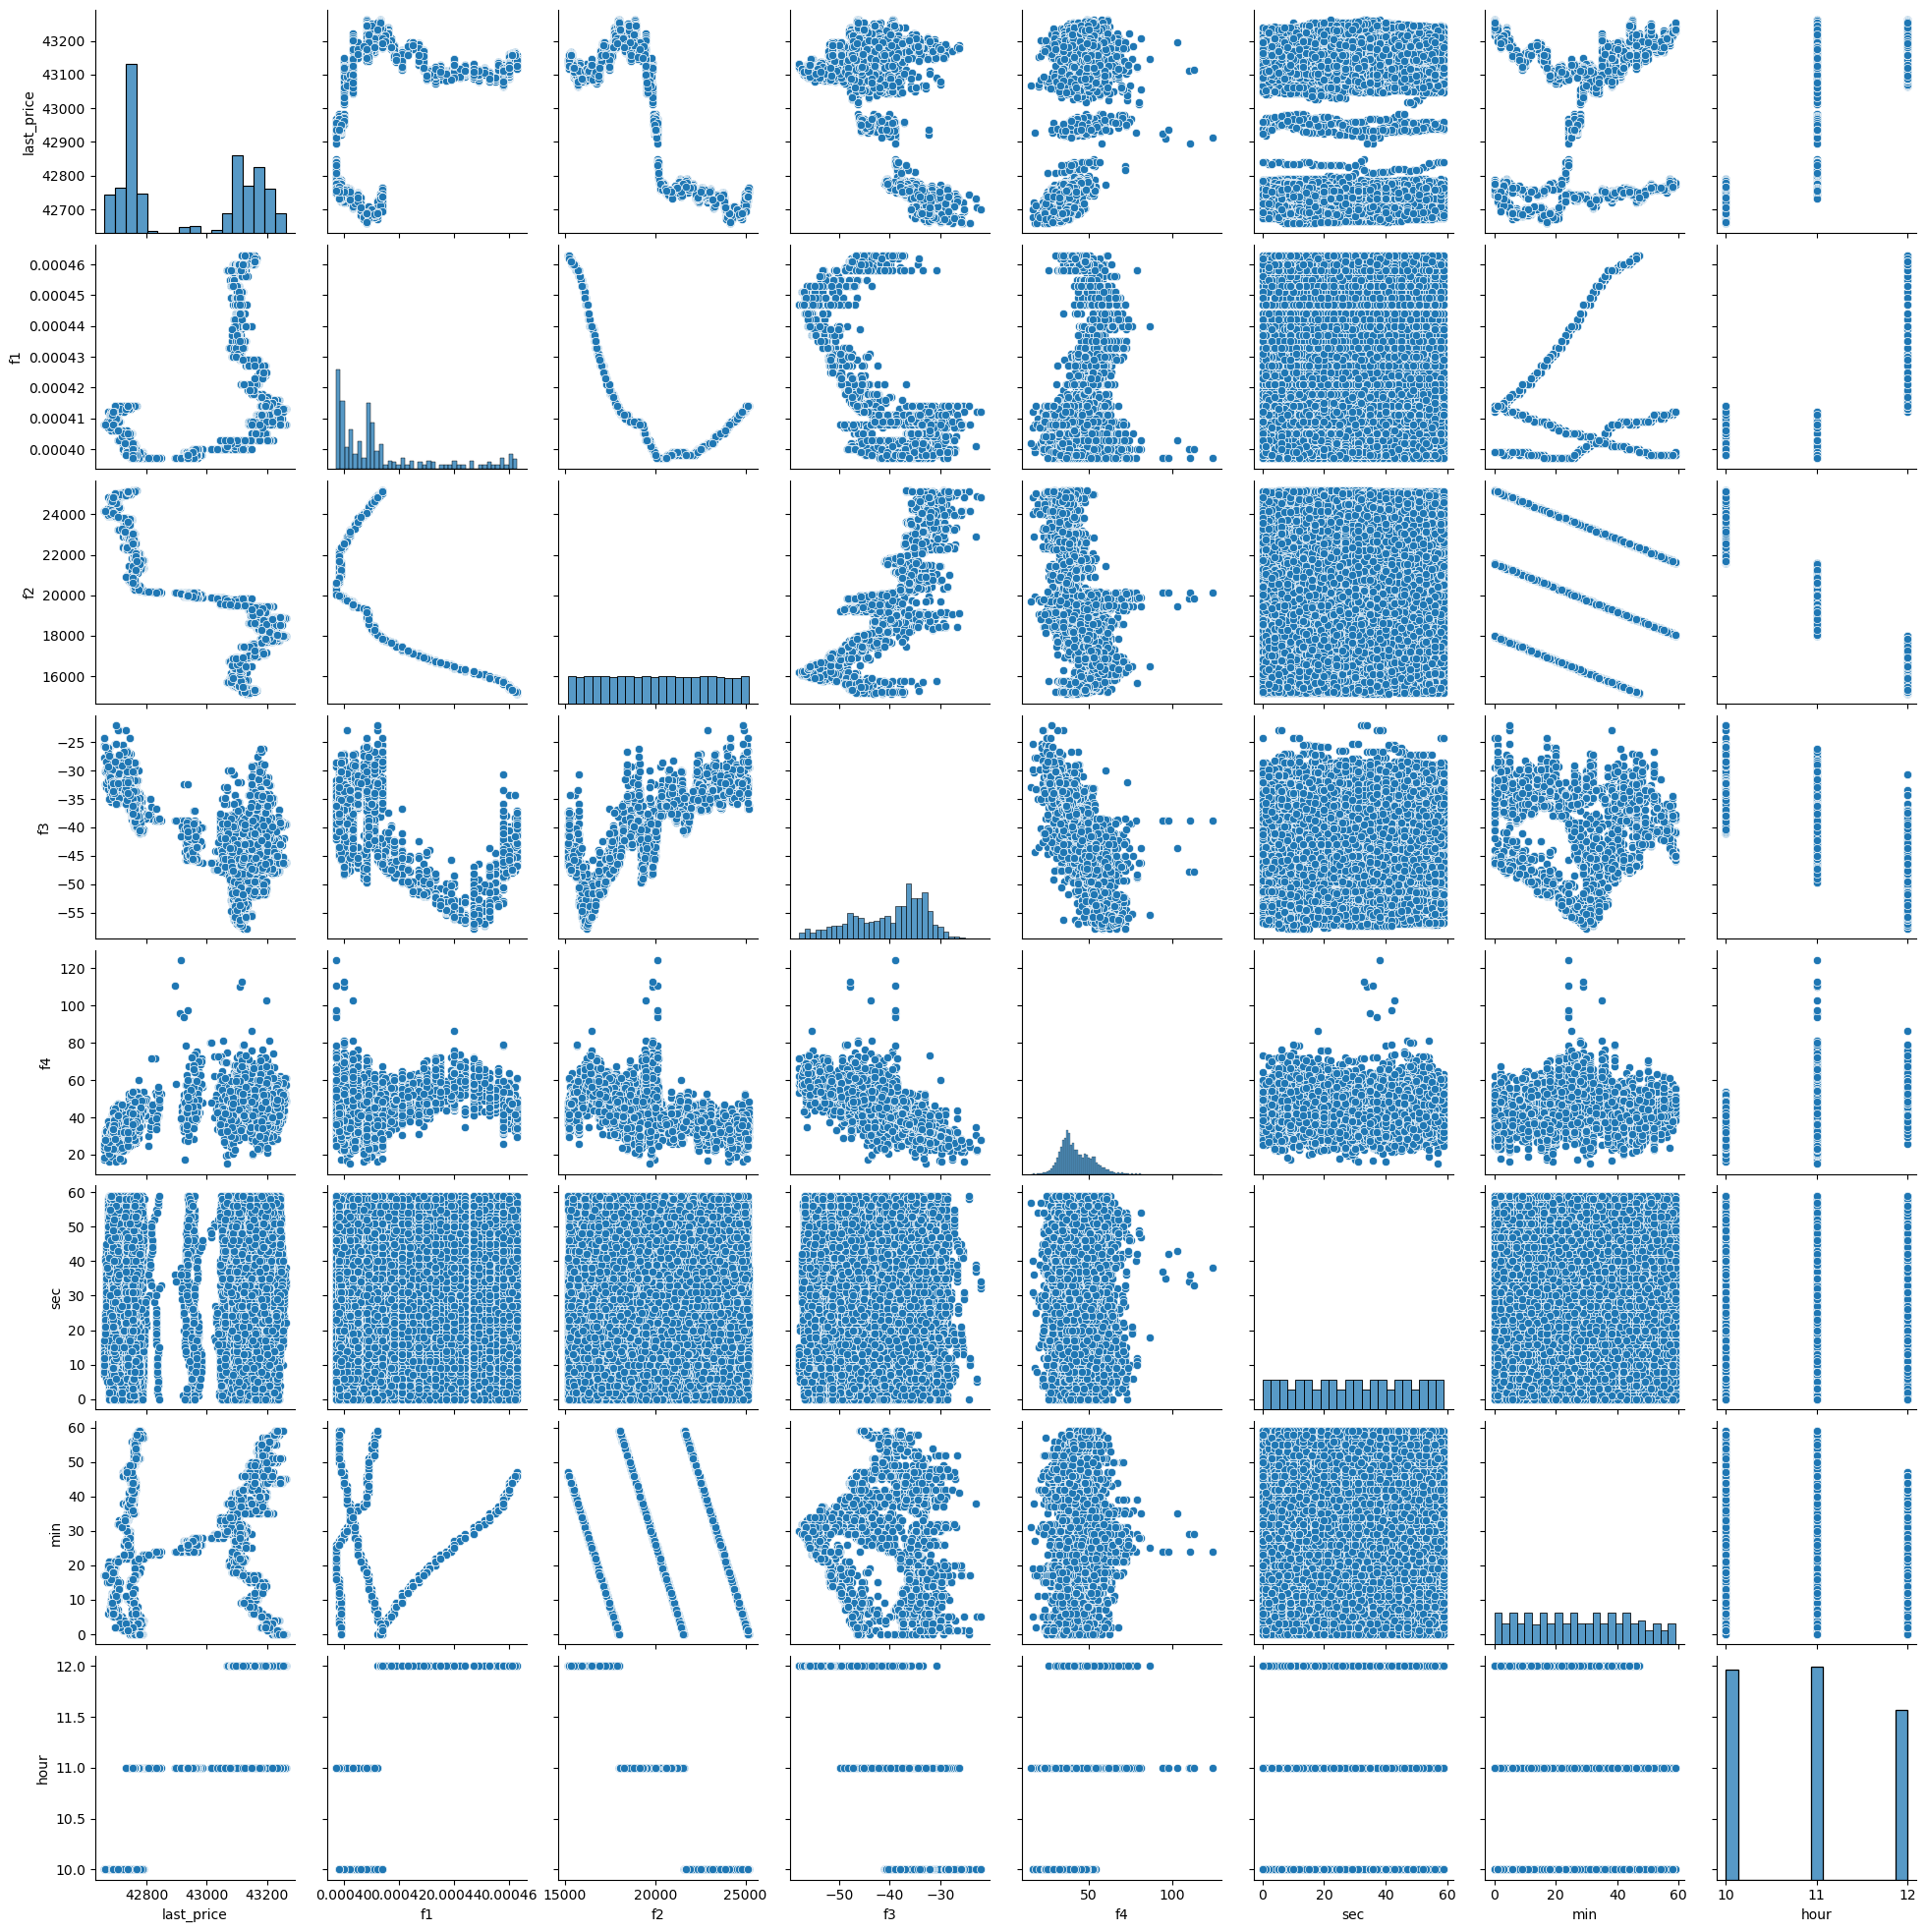

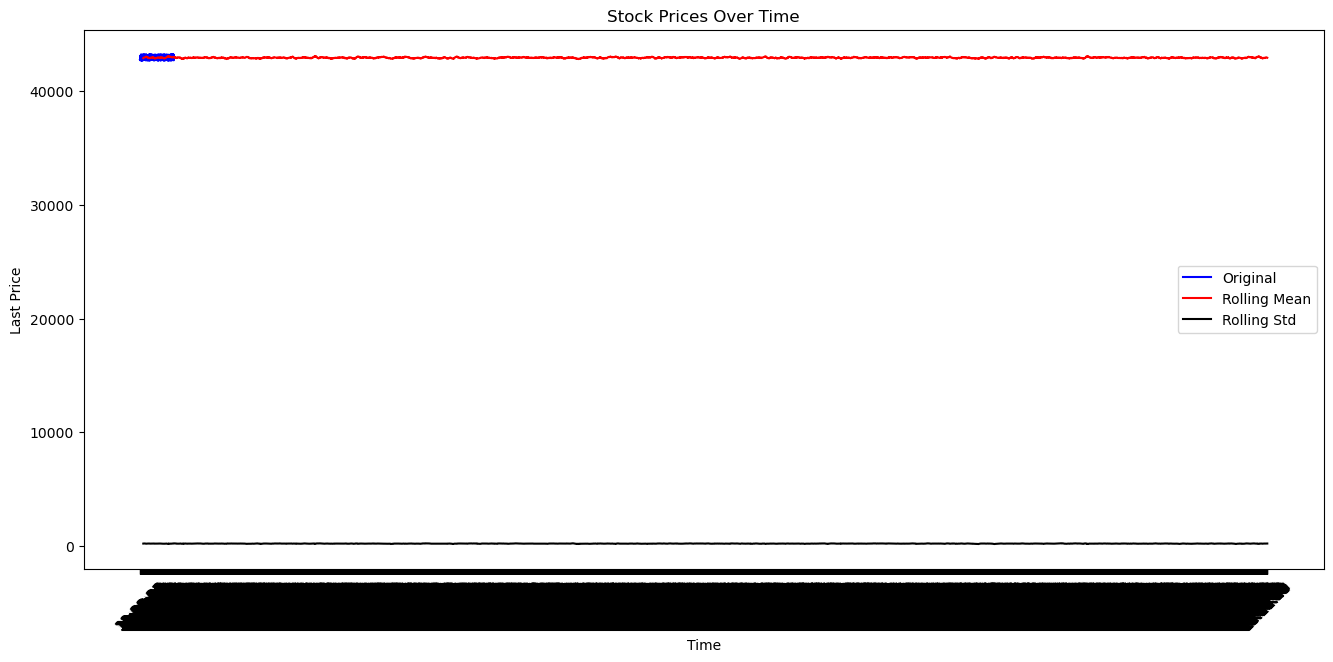

ADF value: -71.791843106903
P-value: 0.0
Accuracy with adjusted threshold: 0.08085532910123622


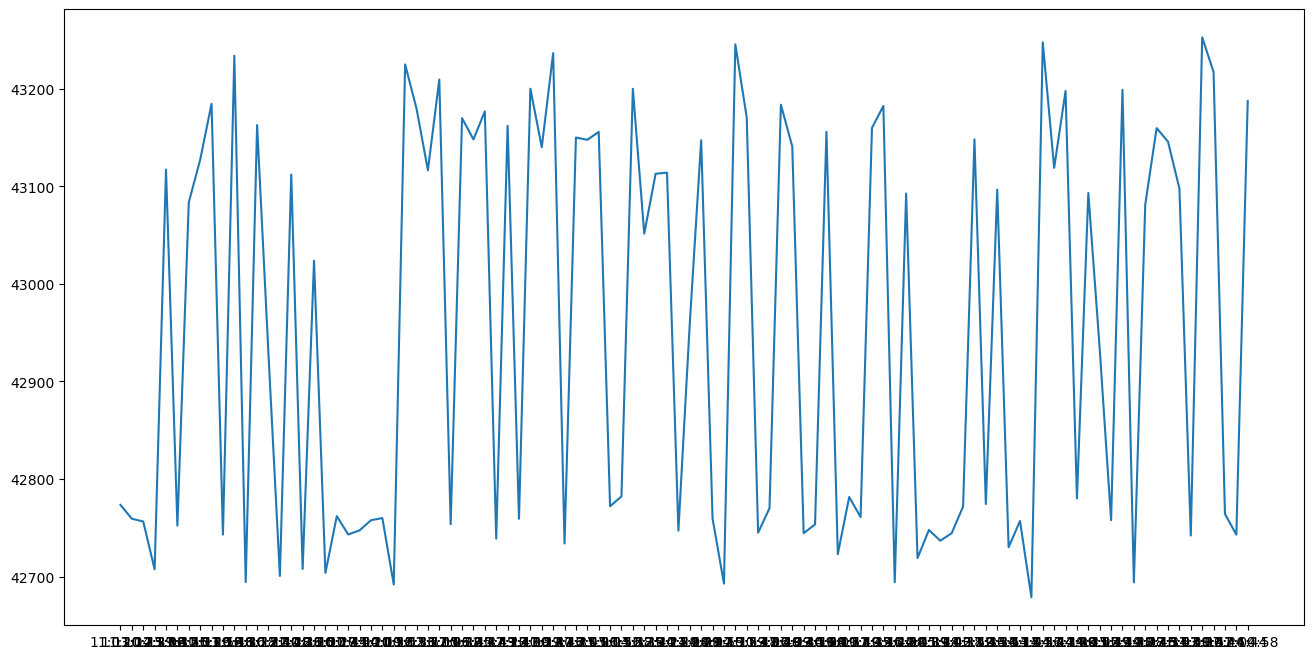

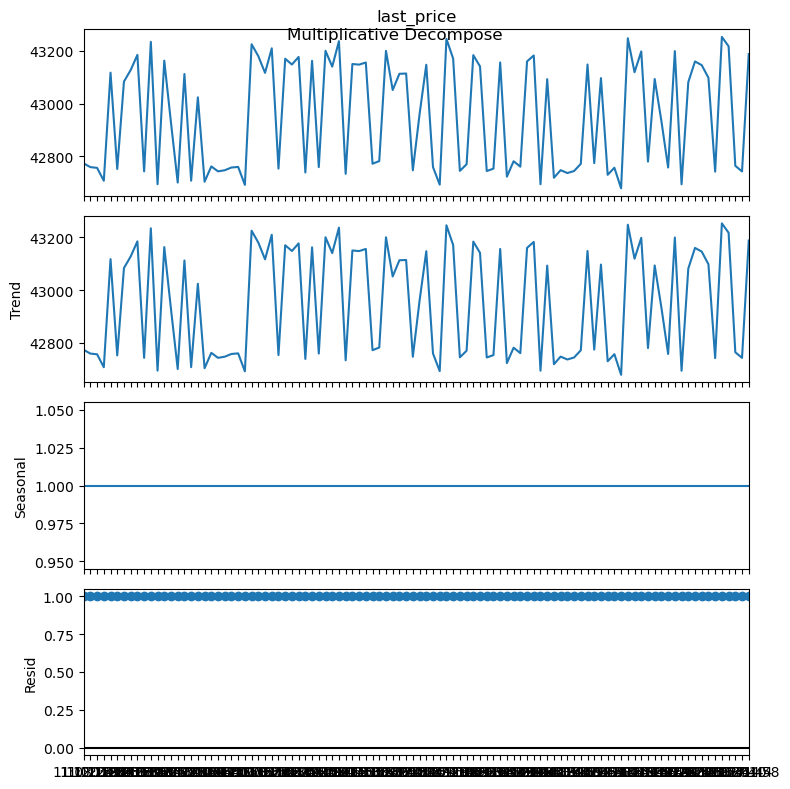

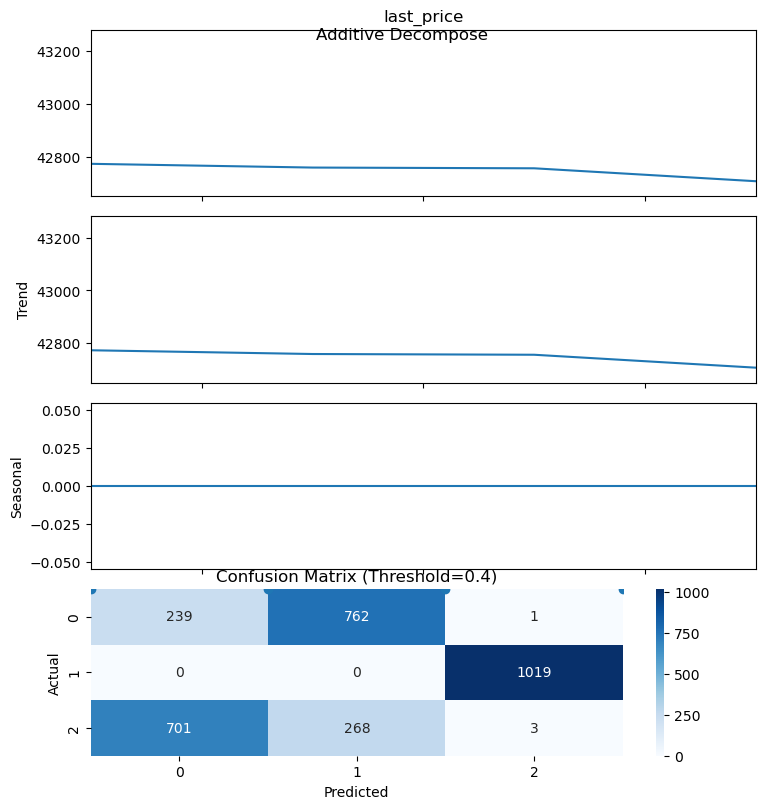

In [16]:
## multi-class label of target 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and preprocess dataset
df = pd.read_csv('Trading-features.csv').dropna().drop_duplicates().sample(frac=1).reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S')  # Combine date and time
df['created_at'] = df['created_at'].dt.strftime('%H:%M:%S')
df.set_index('created_at', inplace=True)
df['last_price'] = pd.to_numeric(df['last_price'], errors='coerce')

# Add new columns for sec, min, and hour
df['sec'] = df['date'].apply(lambda x: int(x[-2:]))
df['min'] = df['date'].apply(lambda x: int(x[-5:-3]))
df['hour'] = df['date'].apply(lambda x: int(x[-8:-6]))

# Pair plot
selected_columns = ['last_price', 'f1', 'f2', 'f3', 'f4', 'sec', 'min', 'hour']
sns.pairplot(df[selected_columns])
plt.show()

# Rolling mean and std
rolmean = df['last_price'].rolling(window=30).mean()
rolstd = df['last_price'].rolling(window=30).std()
plt.figure(figsize=(16, 7))
plt.plot(df['last_price'][:300], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Multiplicative and additive decomposition
plt.rcParams.update({'figure.figsize': (16, 8)})
plt.plot(df['last_price'][:100])
mul_result = seasonal_decompose(df['last_price'][:100], model='multiplicative', period=1)
ad_result = seasonal_decompose(df['last_price'][:100], model='additive', period=1)
plt.rcParams.update({'figure.figsize': (8, 8)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)
plt.rcParams.update({'figure.figsize': (8, 8)})
ad_result.plot().suptitle('\nAdditive Decompose', fontsize=12)

# Augmented Dickey-Fuller test
adf_result = adfuller(df['last_price'], autolag='AIC')
print('ADF value:', adf_result[0])
print('P-value:', adf_result[1])

# Create multiclass target variable using shift
df['target'] = df['last_price'].diff().apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# Oversampling to balance the data for multiclass
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(df.drop(['target'], axis=1), df['target'])

# Drop non-numeric columns and Confusion Matrix and SVC Model
X = X_resampled.select_dtypes(include=['float64', 'int64'])
y = y_resampled

# Feature Scaling (important for non-linear SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100)

# Train multiclass SVC model with probability=True and an RBF kernel
svc_model = SVC(kernel='rbf', probability=True).fit(X_train, y_train)

y_prob = svc_model.predict_proba(X_test)

# Adjust threshold and evaluate accuracy
threshold = 0.4  # Adjust this threshold accordingly
y_pred_adjusted = [1 if prob[1] > threshold else (0 if prob[0] > threshold else -1) for prob in y_prob]
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print(f"Accuracy with adjusted threshold: {accuracy_adjusted}")

# Confusion Matrix with adjusted threshold
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold={threshold})')
plt.show()


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.utils import shuffle
import numpy as np

# Load the dataset
df = pd.read_csv('Trading-features.csv')

# Create a column for price changes using shift
df['PriceChange'] = df['last_price'] - df['last_price'].shift(1)

# Create a column for the target variable
df['Target'] = np.sign(df['PriceChange'])

# Create a new column for encoding increasing, decreasing, or remaining the same
df['TrendType'] = pd.cut(df['PriceChange'], bins=[-float('inf'), -0.001, 0.001, float('inf')], labels=['Decreasing', 'RemainSame', 'Increasing'], include_lowest=True)

# Separate time span into sec, min, and hour
df['created_at'] = pd.to_datetime(df['created_at'])
df['Second'] = df['created_at'].dt.second
df['Minute'] = df['created_at'].dt.minute
df['Hour'] = df['created_at'].dt.hour

# Drop unnecessary columns
df = df.drop(['id', 'PriceChange', 'created_at', 'Target'], axis=1)

# Clean the data by removing any NaN values
df = df.dropna()

# Separate features and target variable
X = df.drop('TrendType', axis=1)
y = df['TrendType']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Randomize the data
X_shuffled, y_shuffled = shuffle(X_scaled, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

# Define the SVC model
model = SVC()

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto']}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Fit the model with the best parameters
best_model = SVC(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

# ADF Test for stationarity on 'last_price'
adf_result = adfuller(df['last_price'])
print(f'\nADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')


Accuracy: 0.40180360721442887
Confusion Matrix:
[[ 85 189 356]
 [ 71 178 379]
 [ 72 127 539]]
Classification Report:
              precision    recall  f1-score   support

  Decreasing       0.37      0.13      0.20       630
  Increasing       0.36      0.28      0.32       628
  RemainSame       0.42      0.73      0.54       738

    accuracy                           0.40      1996
   macro avg       0.39      0.38      0.35      1996
weighted avg       0.39      0.40      0.36      1996


ADF Statistic: -0.815713665971305
p-value: 0.8144626648142248
Critical Values:
   1%: -3.431007319632983
   5%: -2.8618304960194183
   10%: -2.566924625895205
